# Global Difference Analysis using Persistence Landscapes

This notebook evaluates whether the **persistence landscapes** (PLs) obtained from **persistent path homology** computations (i.e., Betti number series) for all pathways show a **global difference between control and disease conditions** in a homological dimension: Dimension 0 (connected components) and (Dimension 1: cycles).

For each dimension, the PLs from all pathways are:
1. Averaged within each group (control and disease).
2. Compared by taking their difference.
3. Quantified using three norms that capture different types of variation:
     - **1-norm**: total accumulated (global) difference (total absolute difference)
     - **2-norm**: emphasizes large but localized deviations (Euclidean distance)
     - **sup-norm**: captures the maximum pointwise deviation (maximum deviation)

A **permutation test** is performed for each norm to determine whether the observed difference could occur by chance. The resulting $p$-values are corrected using the **Benjamini–Hochberg procedure (FDR $< 0.05$)** to assess statistical significance.
The analysis determines which norms show significant differences between **control** and **disease** groups and in which **homological dimension** the difference occurs — whether in dimension 0, dimension 1, or both.


In [ ]:
import numpy as np                   # Numerical computations, array and matrix handling
import pickle                        # Load saved persistence diagrams and intermediate data
from persim import PersLandscapeApprox      # Approximate persistence landscapes from diagrams
from persim.landscapes import average_approx, snap_pl  # Averaging and aligning (snapping) landscapes
from persim.landscapes import plot_landscape_simple    # Quick plotting utility for persistence landscapes
#from statsmodels.stats.multitest import multipletests  # Multiple testing correction (e.g., Benjamini–Hochberg)
import matplotlib.pyplot as plt      # Visualization of persistence landscapes and results
from utils import plot_persistent_barcode, plot_persistent_diagrams  # Helper functions for plotting PDs and barcode
from run_analysis import global_difference_analysis # Load global analysis function


In [2]:
# Load the persistent pairs obtained from PPH computation.
# The file contains a dictionary structured as:
# {dimension (0 or 1) → pathway ID (KEGG hsa codes) → condition ('control' or 'disease') → persistence pairs}
with open("persistent_pairs_dict.pkl", "rb") as f:
    persistent_pairs_dict = pickle.load(f)


In [3]:
# List of IDs of pathways (KEGG hsa codes for GenPath-PPH) to analyzed. 
path_ids = ['hsa00230', 'hsa00380', 'hsa04141', 'hsa04010', 'hsa04014', 
                   'hsa04015', 'hsa04310', 'hsa04350', 'hsa04630', 'hsa04150', 
                   'hsa04110', 'hsa04216', 'hsa04115', 'hsa04660', 'hsa04657',
                   'hsa02010', 'hsa04012', 'hsa04330', 'hsa04340', 'hsa04390',
                   'hsa04370', 'hsa04371', 'hsa04064', 'hsa04066', 'hsa04668', 
                   'hsa04068', 'hsa04020', 'hsa04070', 'hsa04072', 'hsa04071', 
                   'hsa04022', 'hsa04024', 'hsa04151', 'hsa04152', 'hsa04080', 
                   'hsa04060', 'hsa04061', 'hsa04512', 'hsa04514', 'hsa04710',
                   'hsa00970', 'hsa03008', 'hsa03010', 'hsa03040', 'hsa03013', 
                   'hsa03015', 'hsa03020', 'hsa03060', 'hsa03022', 'hsa04130',
                   'hsa03018', 'hsa03030', 'hsa03050', 'hsa03082', 'hsa03083', 
                   'hsa03250', 'hsa03260', 'hsa03264', 'hsa03265', 'hsa03266',
                   'hsa04122', 'hsa03267', 'hsa03410', 'hsa03420', 'hsa04750', 
                   'hsa04713', 'hsa04714', 'hsa04211', 'hsa04360', 'hsa04380', 
                   'hsa04744', 'hsa04740', 'hsa04742', 'hsa03430', 'hsa03440', 
                   'hsa03450', 'hsa03460', 'hsa04120', 'hsa04720', 'hsa04721', 
                   'hsa04722', 'hsa04723', 'hsa04724', 'hsa04725', 'hsa04726', 
                   'hsa04727', 'hsa04728', 'hsa04730', 'hsa04962', 'hsa04960',
                   'hsa04260', 'hsa04261', 'hsa04270', 'hsa04970', 'hsa04971',
                   'hsa04972', 'hsa04973', 'hsa04974', 'hsa04975', 'hsa04976',
                   'hsa04977', 'hsa04978', 'hsa04979', 'hsa04964', 'hsa04966',
                   'hsa03320', 'hsa04614', 'hsa04910', 'hsa04911', 'hsa04912',
                   'hsa04913', 'hsa04914', 'hsa04915', 'hsa04916', 'hsa04917',
                   'hsa04918', 'hsa04919', 'hsa04920', 'hsa04921', 'hsa04922',
                   'hsa04923', 'hsa04924', 'hsa04925', 'hsa04926', 'hsa04927',
                   'hsa04928', 'hsa04929', 'hsa04935', 'hsa04961', 'hsa04664',
                   'hsa04062', 'hsa04610', 'hsa04611', 'hsa04612', 'hsa04613',
                   'hsa04620', 'hsa04621', 'hsa04622', 'hsa04623', 'hsa04625',
                   'hsa04640', 'hsa04650', 'hsa04658', 'hsa04659', 'hsa04662',
                   'hsa04670', 'hsa04666', 'hsa04672', 'hsa00640', 'hsa00650',
                   'hsa00010', 'hsa00020', 'hsa00030', 'hsa00040', 'hsa00051',
                   'hsa00052', 'hsa00053', 'hsa00500', 'hsa00520', 'hsa00562',
                   'hsa00620', 'hsa00630', 'hsa00910', 'hsa00920', 'hsa01040',
                   'hsa00061', 'hsa00062', 'hsa00071', 'hsa00100', 'hsa00120',
                   'hsa00140', 'hsa00190', 'hsa00240', 'hsa00561', 'hsa00564',
                   'hsa00565', 'hsa00590', 'hsa00591', 'hsa00592', 'hsa00600',
                   'hsa00220', 'hsa00250', 'hsa00260', 'hsa00270', 'hsa00280',
                   'hsa00290', 'hsa00310', 'hsa00330', 'hsa00340', 'hsa00350',
                   'hsa00360', 'hsa00400', 'hsa00410', 'hsa00430', 'hsa00440',
                   'hsa00450', 'hsa00470', 'hsa00480', 'hsa00750', 'hsa00760',
                   'hsa00130', 'hsa00510', 'hsa00511', 'hsa00512', 'hsa00513',
                   'hsa00514', 'hsa00515', 'hsa00531', 'hsa00532', 'hsa00533',
                   'hsa00534', 'hsa00780', 'hsa00830', 'hsa00563', 'hsa00601',
                   'hsa00603', 'hsa00604', 'hsa00670', 'hsa00785', 'hsa00860',
                   'hsa00730', 'hsa00740', 'hsa00770', 'hsa00790', 'hsa00983',
                   'hsa00232', 'hsa00524', 'hsa00900', 'hsa00980', 'hsa00982',
                   'hsa04114', 'hsa04136', 'hsa04137', 'hsa04140', 'hsa04142',
                   'hsa04144', 'hsa04145', 'hsa04146', 'hsa04210', 'hsa04213',
                   'hsa04215', 'hsa04217', 'hsa04218', 'hsa04392', 'hsa04510',
                   'hsa04520', 'hsa04530', 'hsa04540', 'hsa04550', 'hsa04810',
                   'hsa04814']

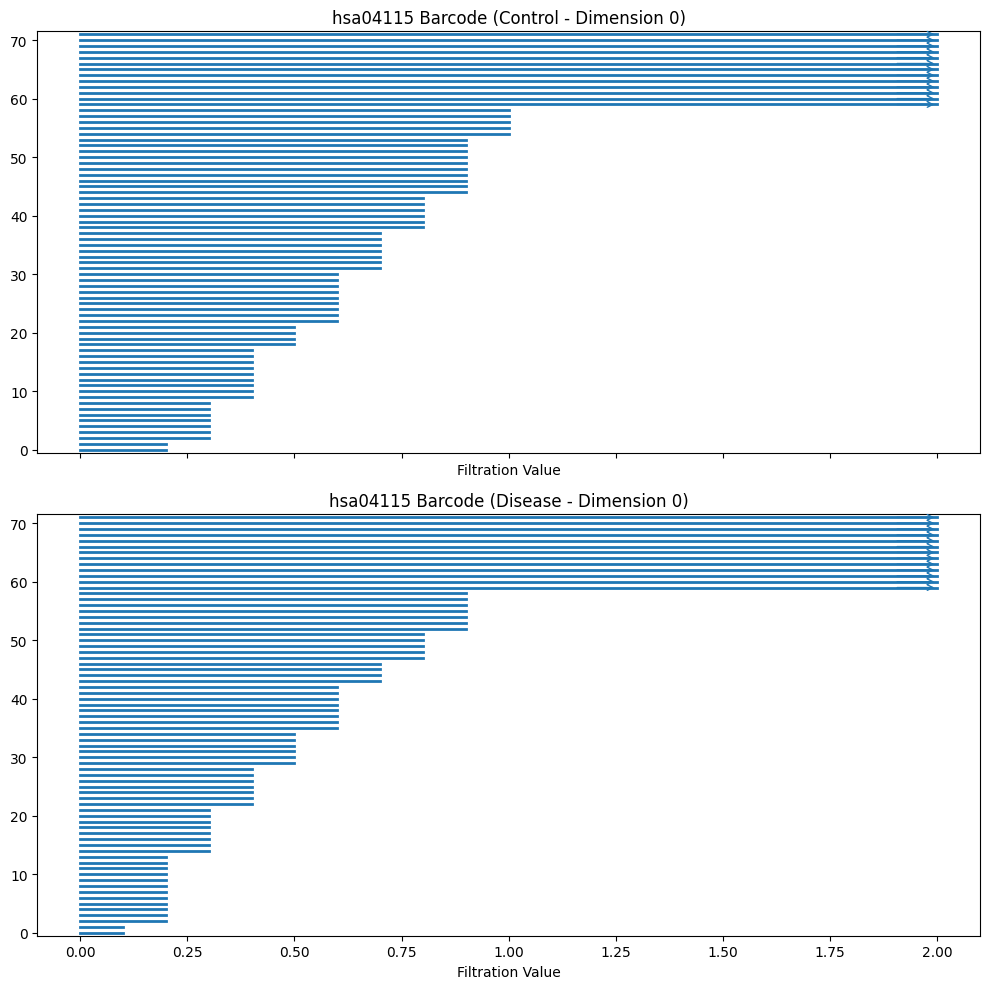

In [4]:
##      
# Example usage (Dimension 0)
##
path_id = 'hsa04115' # Pathway ID (KEGG hsa codes) - p53 signaling pathway

# Load the persistent pairs
pers_pairs_control = persistent_pairs_dict['0'][path_id]['control']
pers_pairs_disease = persistent_pairs_dict['0'][path_id]['disease']

# Plot the persistent barcodes in subplot format, with an option to save the plot
plot_persistent_barcode(path_id, pers_pairs_control, pers_pairs_disease, dim=0, distance_type='absolute', save_plot=False)

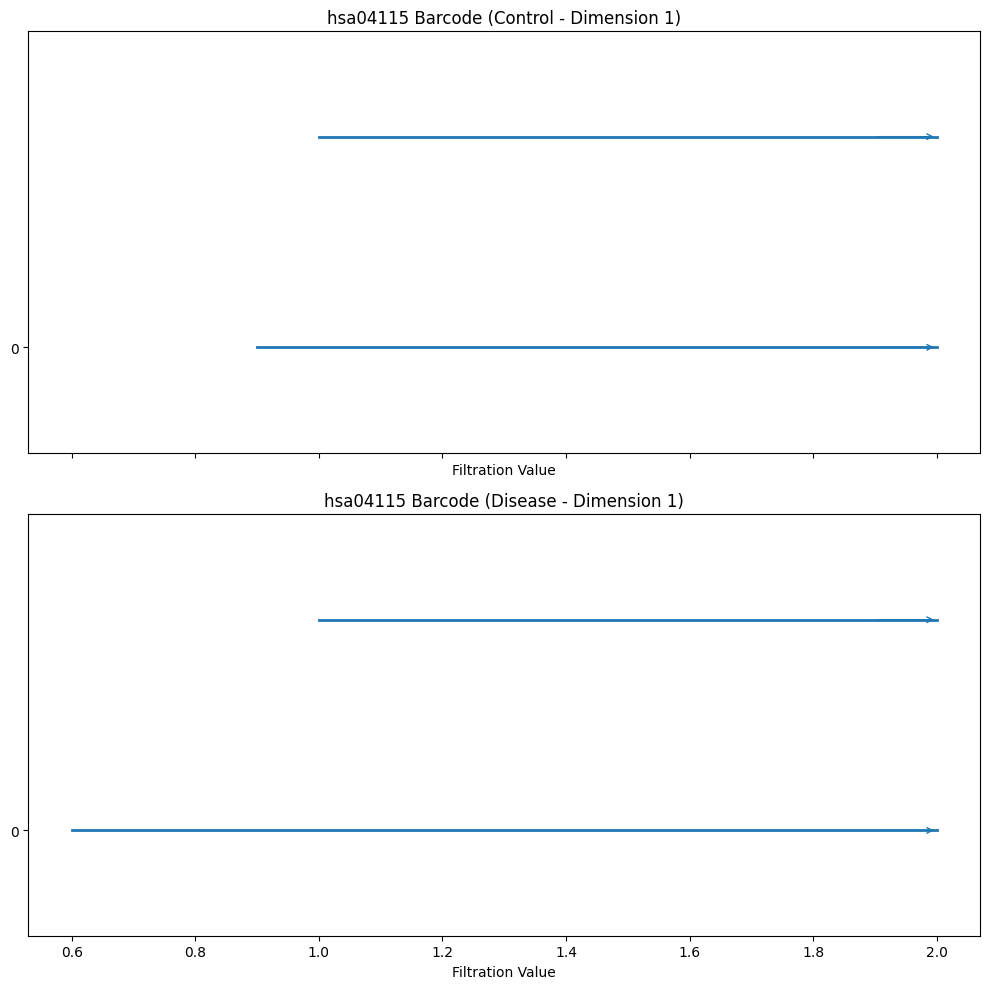

In [5]:
##      
# Example usage (Dimension 1)
##
path_id = 'hsa04115' # Pathway ID (KEGG hsa codes) - p53 signaling pathway

# Load the persistent pairs
pers_pairs_control = persistent_pairs_dict['1'][path_id]['control']
pers_pairs_disease = persistent_pairs_dict['1'][path_id]['disease']

# Plot the persistent barcodes in subplot format, with an option to save the plot
plot_persistent_barcode(path_id, pers_pairs_control, pers_pairs_disease, dim=1, distance_type='absolute', save_plot=False)

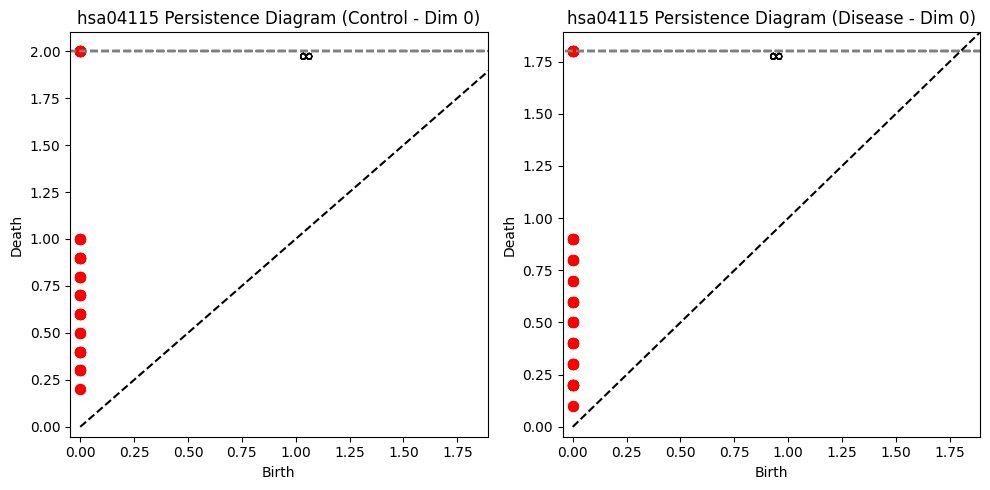

In [6]:
##
# Example usage (Dimension 0)
##
path_id = 'hsa04115' # Pathway ID (KEGG hsa codes) - p53 signaling pathway

# Load the persistent pairs
pers_pairs_control = persistent_pairs_dict['0'][path_id]['control']
pers_pairs_disease = persistent_pairs_dict['0'][path_id]['disease']

# Plot the persistent diagrams in subplot format, with an option to save the plot
plot_persistent_diagrams(path_id, pers_pairs_control, pers_pairs_disease, dim=0, distance_type='absolute', save_plot=False)

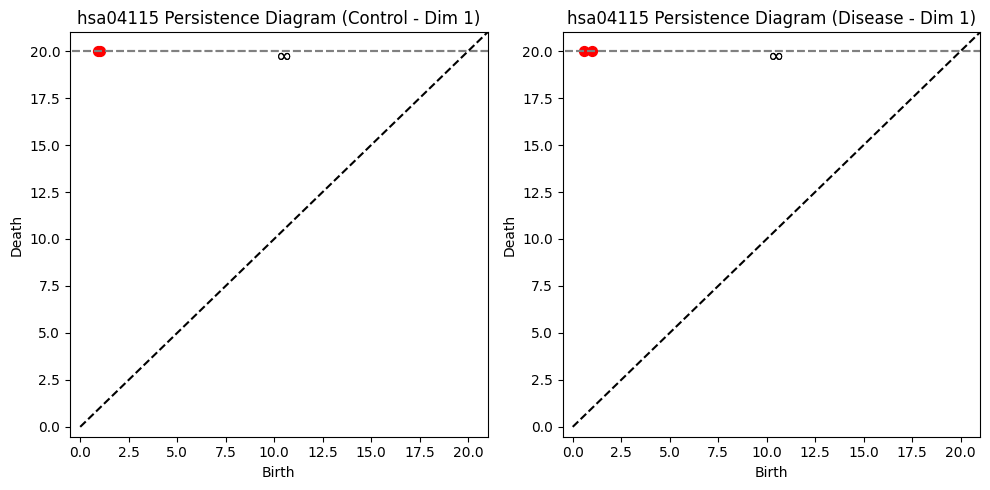

In [7]:
##
# Example usage (Dimension 1)
##
path_id = 'hsa04115' # Pathway ID (KEGG hsa codes) - p53 signaling pathway

# Load the persistent pairs
pers_pairs_control = persistent_pairs_dict['1'][path_id]['control']
pers_pairs_disease = persistent_pairs_dict['1'][path_id]['disease']

# Plot the persistent diagrams in subplot format, with an option to save the plot
plot_persistent_diagrams(path_id, pers_pairs_control, pers_pairs_disease, dim=1, distance_type='absolute', save_plot=False)

### Compute persistence landscapes

In [8]:
# Convert a list of persistence pairs into format required by Persim
def persim_ready_diagram(diagram):
    """
    Convert a list of persistence pairs (tuples) into a NumPy array 
    compatible with Persim functions.
    """
    diagrams_persim = [[list(pair)] for pair in diagram]
    flattened_diagram = [inner for outer in diagrams_persim for inner in outer]
    result = np.array(flattened_diagram)
    return result

# Check if a persistence landscape object is valid
def is_valid_pl(pl):
    """Return True if the persistence landscape has numeric values."""
    try:
        return hasattr(pl, 'values') and isinstance(pl.values, np.ndarray) and pl.values.size > 0
    except Exception:
        return False

In [9]:
# Create pds_control with the desired structure
pds_control = [
    [np.array(persistent_pairs_dict[dim][path_id]['control']) for dim in ['0', '1']]  # dim0 and dim1
    for path_id in path_ids
]

# Create pds_disease with the desired structure
pds_disease = [
    [np.array(persistent_pairs_dict[dim][path_id]['disease']) for dim in ['0', '1']]  # dim0 and dim1
    for path_id in path_ids
]

In [10]:
# Compute persisstence lansdscapes
approx_persistent_landscapes = {
    0: {},
    1: {}
}

for dim in [0, 1]:
    for idx, path_id in enumerate(path_ids):
        # Check if there are empty arrays in both control and disease diagrams
        control_empty = len(pds_control[idx][dim]) == 0 or pds_control[idx][dim].size == 0
        disease_empty = len(pds_disease[idx][dim]) == 0 or pds_disease[idx][dim].size == 0

        if control_empty or disease_empty:
            # If either diagram is empty, append 0 to observed_statistics and skip this iteration
            approx_persistent_landscapes[dim][path_id] = {'control': np.nan, 'disease': np.nan}  # Append nan instead of overwriting
            continue

        if np.all(np.isinf(pds_control[idx][dim][:, 1])) or np.all(np.isinf(pds_disease[idx][dim][:, 1])):
            #print("All death times are infinity, skipping this persistence diagram.")
            approx_persistent_landscapes[dim][path_id] = {'control': np.nan, 'disease': np.nan}  # Append nan instead of overwriting
            continue

        # Calculate landscapes for valid data
        landscape_control = PersLandscapeApprox(dgms=pds_control[idx], hom_deg=dim)
        landscape_disease = PersLandscapeApprox(dgms=pds_disease[idx], hom_deg=dim)

        approx_persistent_landscapes[dim][path_id] = {
            'control': landscape_control,
            'disease': landscape_disease
        } 
    print(f"Done dimension {dim}")
        
# Output the final observed_statistics
#print(approx_persistent_landscapes)

Done dimension 0
Bad choice of grid, values is empty
Bad choice of grid, values is empty
Bad choice of grid, values is empty
Bad choice of grid, values is empty
Done dimension 1


In [11]:
# Extract persistence landscapes per condition and dimension
cpls_0 = [approx_persistent_landscapes[0][p]['control'] for p in approx_persistent_landscapes[1].keys()]
dpls_0 = [approx_persistent_landscapes[0][p]['disease'] for p in approx_persistent_landscapes[1].keys()]
cpls_1 = [approx_persistent_landscapes[1][p]['control'] for p in approx_persistent_landscapes[1].keys()]
dpls_1 = [approx_persistent_landscapes[1][p]['disease'] for p in approx_persistent_landscapes[1].keys()]

### Compute average persistence landscapes for dimension 0

In [12]:
cpls_0_snap, dpls_0_snap = [], []
for cpl, dpl in zip(cpls_0, dpls_0):
    if is_valid_pl(cpl) and is_valid_pl(dpl):
        try:
            c_snap, d_snap = snap_pl([cpl, dpl])
            cpls_0_snap.append(c_snap)
            dpls_0_snap.append(d_snap)
        except Exception as e:
            print(f"Skipped invalid pair (dim 0): {e}")

if cpls_0_snap and dpls_0_snap:
    avg_cpl_0 = average_approx(cpls_0_snap)
    avg_dpl_0 = average_approx(dpls_0_snap)
    print("✅ Dimension 0 average computed.")
else:
    print("⚠️ No valid landscapes found for dimension 0.")

✅ Dimension 0 average computed.


### Compute average persistence landscapes for dimension 1

In [13]:
cpls_1_snap, dpls_1_snap = [], []
for cpl, dpl in zip(cpls_1, dpls_1):
    if is_valid_pl(cpl) and is_valid_pl(dpl):
        try:
            c_snap, d_snap = snap_pl([cpl, dpl])
            cpls_1_snap.append(c_snap)
            dpls_1_snap.append(d_snap)
        except Exception as e:
            print(f"Skipped invalid pair (dim 1): {e}")

if cpls_1_snap and dpls_1_snap:
    avg_cpl_1 = average_approx(cpls_1_snap)
    avg_dpl_1 = average_approx(dpls_1_snap)
    print("✅ Dimension 1 average computed.")
else:
    print("⚠️ No valid landscapes found for dimension 1.")

Skipped invalid pair (dim 1): object of too small depth for desired array
Skipped invalid pair (dim 1): object of too small depth for desired array
Skipped invalid pair (dim 1): object of too small depth for desired array
Skipped invalid pair (dim 1): object of too small depth for desired array
✅ Dimension 1 average computed.


In [14]:
# ======================================================
# Display summary
# ======================================================
print(f"Valid persistence landscapes in dimension 0: {len(cpls_0_snap)} | dimension 1: {len(cpls_1_snap)}")

Valid persistence landscapes in dimension 0: 214 | dimension 1: 142


### Plot the persistence landscapes

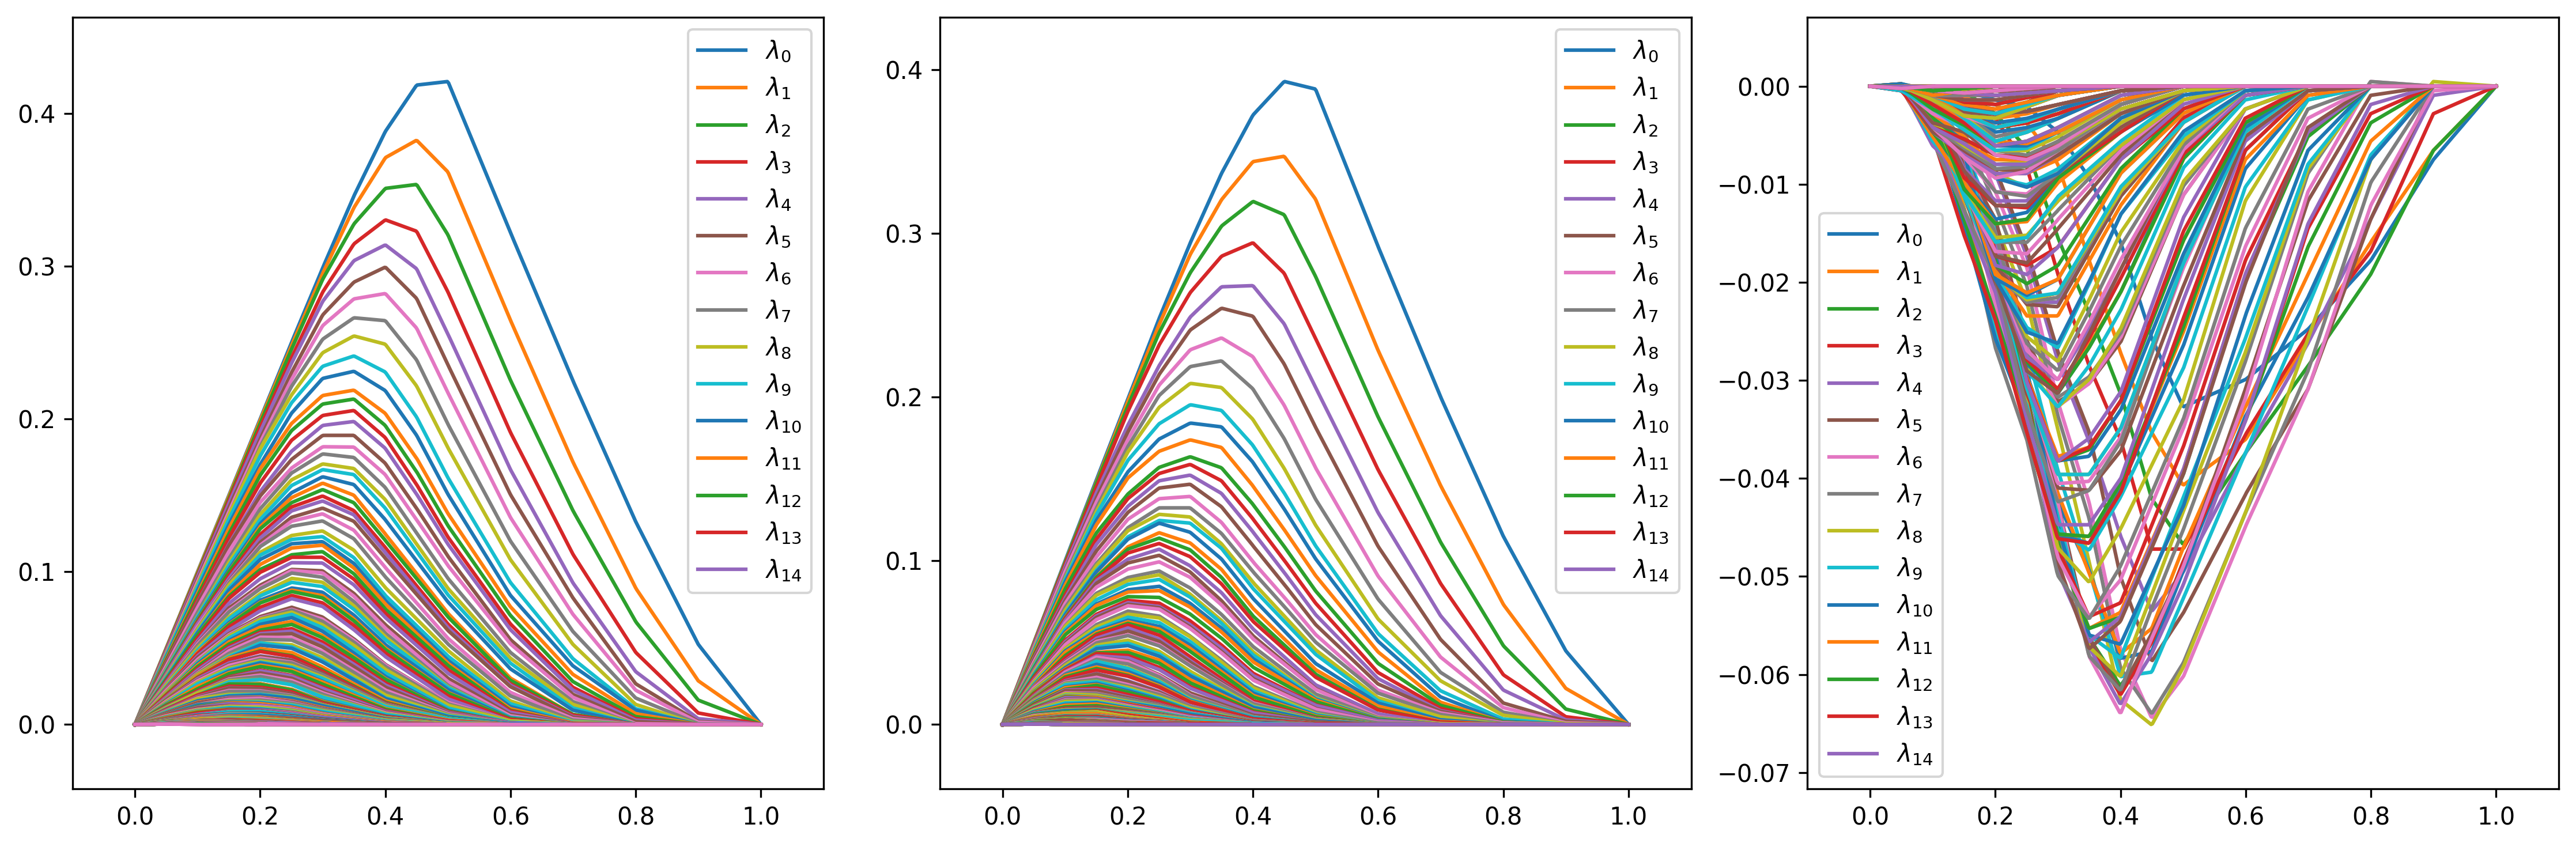

In [15]:
# Dimension 0
fig, axs = plt.subplots(1, 3, dpi=300)
fig.set_size_inches(15, 5)

# Plot control landscape in the first subplot
plot_landscape_simple(avg_cpl_0, ax=axs[0])  # Pass axs[0] as the axis to plot on
my_handles, my_labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[0].set_title("Degree 0 Average Persistence Landscape for Control")  # Set title for the control plot

# Plot disease landscape in the second subplot
plot_landscape_simple(avg_dpl_0, ax=axs[1])  # Pass axs[1] as the axis to plot on
my_handles, my_labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[1].set_title("Degree 0 Average Persistence Landscape for Disease")  # Set title for the disease plot

# Calculate the true (observed difference)
true_diff_pl_0 = avg_dpl_0 - avg_cpl_0

# Plot disease landscape in the second subplot
plot_landscape_simple(true_diff_pl_0, ax=axs[2])  # Pass axs[1] as the axis to plot on
my_handles, my_labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[2].set_title("Difference of Average Persistence Landscapes in Degree 0")  # Set title for the disease plot

# Adjust layout for a clean presentation
fig.tight_layout()

# Display the plot
plt.show()

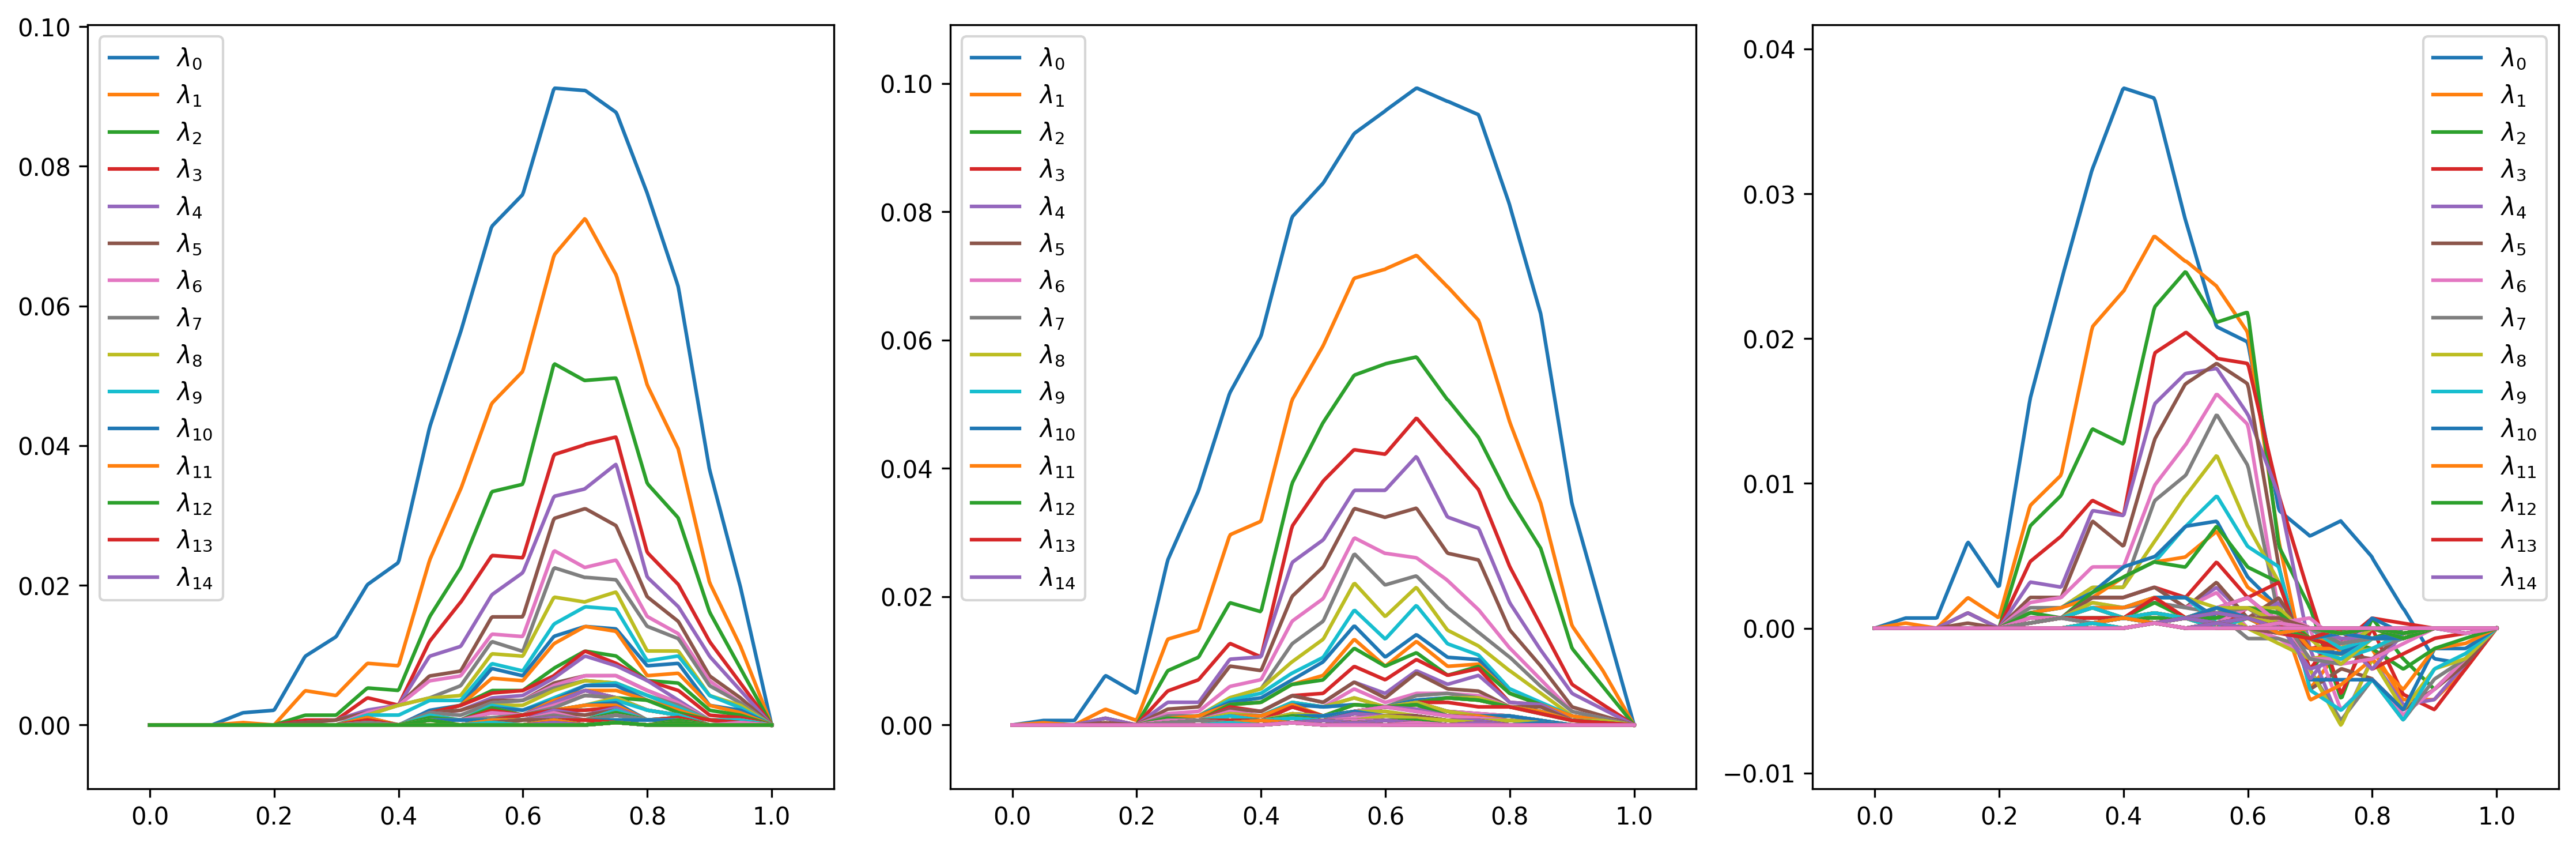

In [16]:
# Dimension 1
fig, axs = plt.subplots(1, 3, dpi=300)
fig.set_size_inches(15, 5)

# Plot control landscape in the first subplot
plot_landscape_simple(avg_cpl_1, ax=axs[0])  # Pass axs[0] as the axis to plot on
my_handles, my_labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[0].set_title("Degree 1 Average Persistence Landscape for Control")  # Set title for the control plot

# Plot disease landscape in the second subplot
plot_landscape_simple(avg_dpl_1, ax=axs[1])  # Pass axs[1] as the axis to plot on
my_handles, my_labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[1].set_title("Degree 1 Average Persistence Landscape for Disease")  # Set title for the disease plot

# Calculate the true (observed difference)
true_diff_pl_1 = avg_dpl_1 - avg_cpl_1

# Plot disease landscape in the second subplot
plot_landscape_simple(true_diff_pl_1, ax=axs[2])  # Pass axs[1] as the axis to plot on
my_handles, my_labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles=my_handles[:15])  # Limit legend to 10 entries
#axs[2].set_title("Difference of Average Persistence Landscapes in Degree 1")  # Set title for the disease plot

# Adjust layout for a clean presentation
fig.tight_layout()

# Display the plot
plt.show()

### Perform the global analysis

In [ ]:
# Run for dimension 0
result_dim0 = global_difference_analysis(cpls_0, dpls_0, num_perms=1000)

Permutation 10/10 completed (for 1-norm)
Permutation 10/10 completed (for 2-norm)
Permutation 10/10 completed (for sup-norm)

Global difference analysis:
Norm 1: measured difference=1.131860, p=0.000000, adj p=0.000000, Significant=True
1-norm shows significant difference between control and disease groups

Norm 2: measured difference=0.185723, p=0.000000, adj p=0.000000, Significant=True
2-norm shows significant difference between control and disease groups

Norm sup: measured difference=0.065089, p=0.000000, adj p=0.000000, Significant=True
sup-norm shows significant difference between control and disease groups



In [ ]:
# Run for dimension 1
result_dim1 = global_difference_analysis(cpls_1, dpls_1, num_perms=1000)